In [1]:
import pymc4 as pm
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
plt.rcParams['figure.figsize'] = (16, 8)
plt.style.use('ggplot')

# 1. 

The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

| Individual | weight | expected height | 89% interval |
|---|---|---|---|
| 0 | 45 | | |
| 1 | 40 | | |
| 2 | 65 | | |
| 3 | 31 | | |
| 4 | 53 | | |
***

#### Step 1: Data Preparation

In [ ]:
data = pd.read_csv('../data/Howell1.csv', sep=';')
adults_data = data.query('age > 18')

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler(with_std=False).fit(adults_data['weight'].to_numpy(dtype=np.float32).reshape(-1, 1))
X = ss.transform(adults_data['weight'].to_numpy(dtype=np.float32).reshape(-1, 1)).squeeze(-1)
y = adults_data['height'].to_numpy(dtype=np.float32)

In [ ]:
plt.scatter(X, y);
plt.xlabel(f'Weight (in kg)\n centered around {ss.mean_[0]:.2f} kg ');
plt.ylabel('Height (in cm)');
plt.title('Howell1 Data - Adults');

In [ ]:
x_test_raw = np.array([45, 40, 65, 31, 53], dtype=np.float32)
x_test = ss.transform(x_test_raw.reshape(-1, 1)).squeeze(-1)
y_test = np.zeros_like(x_test)

#### Step 2: Model Definition

In [ ]:
@pm.model
def linear_model(x, y):
    
    # setting-up priors
    α = yield pm.Normal(name='α', loc=140, scale=25)
    β = yield pm.Normal(name='β', loc=0, scale=10)
    σ = yield pm.Uniform(name='σ', low=0, high=50)

    # expected value of the linear model
    μ = yield pm.Deterministic(name='μ', value=α + β*x)
    
    # defining likilhood
    liklihood = yield pm.Normal(name='liklihood', loc=μ, scale=σ, observed=y)
    return liklihood

#### Step 3: Inference

In [ ]:
trace = pm.sample(model=linear_model(x=X, y=y))

In [ ]:
sampled_vars = [f"linear_model/{v}" for v in ['α', 'β', 'σ']]

In [ ]:
az.plot_trace(trace, var_names=sampled_vars);

#### Step 4: Prediction

In [ ]:
ppc = pm.sample_posterior_predictive(model=linear_model(x=x_test, y=y_test), 
                                     trace=trace, inplace=False)

In [ ]:
az.summary(ppc.posterior_predictive, credible_interval=0.89, kind='stats').reset_index().set_index(x_test_raw).rename_axis('weight')

In [ ]:
az.plot_posterior(ppc.posterior_predictive, credible_interval=0.89);

# 2. 
Model the relationship between height (cm) and the natural logarithm of weight (log-kg): log(weight). Use the entire Howell1 data frame, all 544 rows, adults and non-adults. Use any model type from Chapter 4 that you think useful: an ordinary linear regression, a polynomial or a spline. Plot the posterior predictions against the raw data.
***

#### Step 1: Data Preparation

In [3]:
data = pd.read_csv('../data/Howell1.csv', sep=';')

In [4]:
x = np.log(data['weight'].values, dtype=np.float32)
y = data['height'].to_numpy(dtype=np.float32)

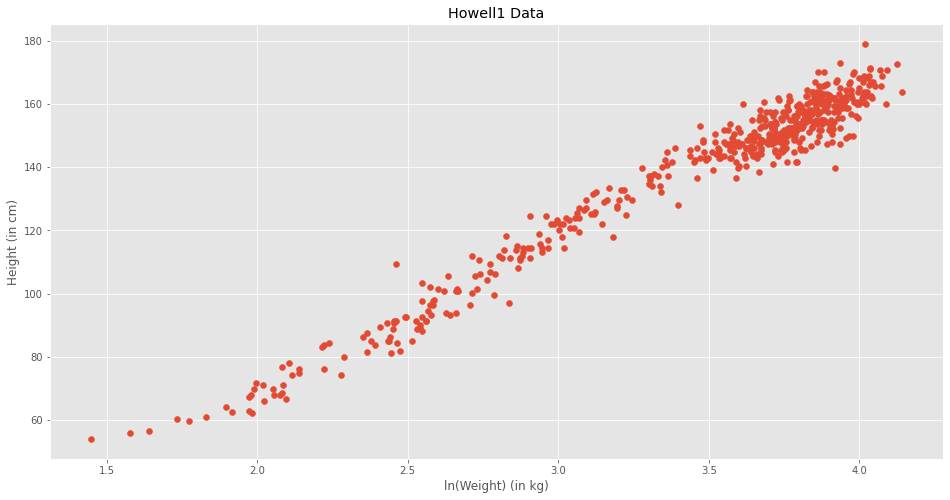

In [5]:
plt.scatter(x, y);
plt.xlabel('ln(Weight) (in kg)');
plt.ylabel('Height (in cm)');
plt.title('Howell1 Data');

#### Step 2: Model Definition

In [9]:
@pm.model
def polynomial_model(x, y, order=1, highest_order_only=False):
    
    # setting-up data
    if highest_order_only:
        X = np.power(np.expand_dims(x, -1), order, dtype=np.float32)
    else:
        _order_arr = np.expand_dims(np.arange(1, order + 1), 0)
        _order_mat = np.repeat(a=_order_arr, repeats=x.shape[0], axis=0)
        X = np.power(np.expand_dims(x, -1), _order_mat, dtype=np.float32)
    
    # setting-up priors
    α = yield pm.Normal(name='α', loc=0, scale=20)
    β = yield pm.Normal(name='β', loc=0, scale=10, plate=1 if highest_order_only else order) # batch_stack ?
    σ = yield pm.HalfNormal(name='σ', loc=0, scale=20)
    
    # expected value of the linear model
    μ = yield pm.Deterministic(name='μ', value=(α + tf.tensordot(X, β, axes=1)))
    
    # likilhood
    yield pm.Normal(name='liklihood', loc=μ, scale=σ, observed=y)


In [10]:
# order = 2
# _order_arr = np.expand_dims(np.arange(1, order + 1), 0)
# _order_mat = np.repeat(a=_order_arr, repeats=X.shape[0], axis=0)
# x = np.power(np.expand_dims(X, -1), _order_mat, dtype=np.float32)

# b = np.random.normal(loc=0, scale=10, size=order).astype(np.float32)
# tf.tensordot(x, b, axes=1).shape

#### Step 3: Inference

In [11]:
model_2 = polynomial_model(x=x, y=y, order=2, highest_order_only=True)
trace_model_2 = pm.sample(model=model_2, burn_in=1000, num_samples=2000)

In [ ]:
sampled_vars = [f"polynomial_model/{v}" for v in ['α', 'β', 'σ']]

In [ ]:
az.plot_trace(trace_model_2, var_names=sampled_vars);

In [ ]:
az.summary(trace_model_2, var_names=sampled_vars)

In [ ]:
az.plot_autocorr(trace_model_2, var_names='polynomial_model/β');

In [ ]:
trace_model_2 = pm.sample_posterior_predictive(model=model_2, trace=trace_model_2)

In [ ]:
az.r2_score(y, 
            trace_model_2.posterior_predictive['polynomial_model/liklihood'].data.reshape(-1, y.shape[0]))